Epoch 1/50
785/785 [==============================] - 1s 642us/step - loss: 0.1081 - acc: 0.9703 - val_loss: 0.1198 - val_acc: 0.9681
Epoch 2/50
785/785 [==============================] - 0s 579us/step - loss: 0.1052 - acc: 0.9709 - val_loss: 0.1111 - val_acc: 0.9683
Epoch 3/50
785/785 [==============================] - 0s 580us/step - loss: 0.1022 - acc: 0.9718 - val_loss: 0.1058 - val_acc: 0.9720
Epoch 4/50
785/785 [==============================] - 0s 554us/step - loss: 0.0998 - acc: 0.9722 - val_loss: 0.1001 - val_acc: 0.9704
Epoch 5/50
785/785 [==============================] - 0s 548us/step - loss: 0.0979 - acc: 0.9722 - val_loss: 0.0936 - val_acc: 0.9712
Epoch 6/50
785/785 [==============================] - 0s 547us/step - loss: 0.0955 - acc: 0.9734 - val_loss: 0.0876 - val_acc: 0.9748
Epoch 7/50
785/785 [==============================] - 0s 564us/step - loss: 0.0927 - acc: 0.9739 - val_loss: 0.0800 - val_acc: 0.9755
Epoch 8/50
785/785 [==============================] - 0s 549us

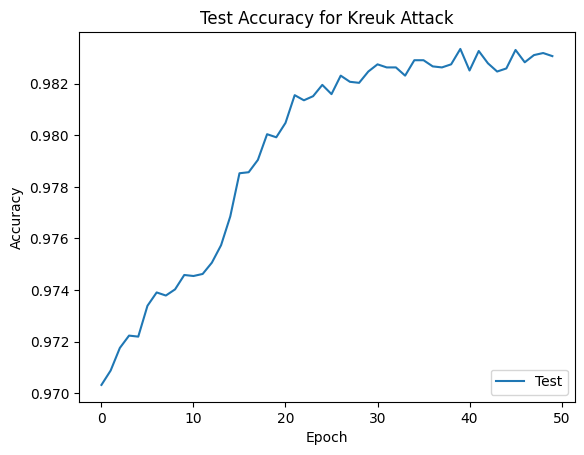

In [12]:
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

model = load_model('my_malconv_model.h5')

file_path = 'dataset_malwares.csv'
df = pd.read_csv(file_path)

selected_features = df[["MinorOperatingSystemVersion", "MajorSubsystemVersion", 
                        "SizeOfStackReserve", "MajorLinkerVersion", 
                        "MajorOperatingSystemVersion", "MinorImageVersion", 
                        "Subsystem", "MinorSubsystemVersion"]]
labels = df["Malware"]

X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

max_size = len(selected_features.columns)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, max_size))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, max_size))

def fgsm(model, X, y, epsilon=0.01):
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    y_array = y.to_numpy().reshape(-1, 1)
    y_tensor = tf.convert_to_tensor(y_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        prediction = model(X_tensor)
        loss = tf.keras.losses.binary_crossentropy(y_tensor, prediction)

    gradient = tape.gradient(loss, X_tensor)
    signed_grad = tf.sign(gradient)
    X_adv = X_tensor + epsilon * signed_grad
    return X_adv.numpy()

X_train_adv = fgsm(model, X_train_scaled, y_train)

X_combined = np.concatenate((X_train_scaled, X_train_adv))
y_combined = np.concatenate((y_train.to_numpy(), y_train.to_numpy()))

history = model.fit(X_combined, y_combined, batch_size=32, epochs=50, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

plt.plot(history.history['acc'], label='Test')

plt.title('Test Accuracy for Kreuk Attack')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
